## Binning Data: Mean and Error Bars

We will now work a toy problem isnpired by the detection of Baryon Accoustic Oscilaltion's in the galacy-galaxy correlation function.  We will simulate a toy model for data with and without correlations, summarize these data with means and error bars, and then introduce and use $\chi^2$ to fit these data and estimate uncertainties on the recovered paramters.


The toy model for the correlation function will be the sum of a power law and a gaussian chosen to approximate the cosmological signal.   $$C(r) = A \left( \frac 1 {10} \right)^{r/50} + B e^{- \frac 1 2 \left( \frac {r-120} {10} \right)^2 }.$$  In generating the model the amplitudes $A$ and $B$ will be fixed to 1 and 0.02 respectively.  When we fit the data we will allow $A$ and $B$ to vary while holding the remaining paratmers fixed.  This toy model will be used to demonstrate statistical technqiues.  This is a carton version of the cosmological measuremnt intened only to illustrate statistical methods.

Our first step is to simulate mesauments of $C(r)$ by treating each bin in $r$ as containing some number of data points that sampel a gaussian distribtion centerd at $C(r)$.  For each bin we compute the mean and variance on the mean which are plotted as a simulated mesurmeent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

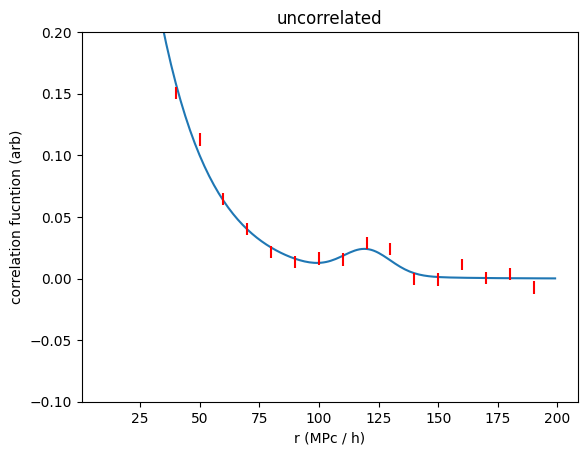

In [2]:
## make a toy modle for the galaxy-galaxy corerlation funciton

r = np.arange(190) + 10
gal_gal_cor_empricial_theory = 1*(1/10.)**(r/50.)+ 0.02*np.exp(-0.5*((r-120)/10.)**2)
plt.plot(r,gal_gal_cor_empricial_theory)
plt.xlabel("r (MPc / h)")
plt.ylabel("correlation fucntion (arb)")


## make simulated data with error bars, no correlation
bin_width = 10. # the sampling of the measurement
N_pts_in_bin  = 1000 # numper of samples used to compute the mean and rms in each bin
N_data_pts = 190 / bin_width  ## number of data points for the plot
sigma_corr = 0.005 * np.sqrt(N_pts_in_bin)  ## uncertainty in the correlatoin fucntion

i = 0
while (i < N_data_pts):
    r_bin  = bin_width*(i+1)
    theory_mean = gal_gal_cor_empricial_theory[(np.where(r == r_bin))[0] ]
    data_in_bin = np.random.randn(N_pts_in_bin)*sigma_corr + theory_mean
    mean_pt = np.mean(data_in_bin)
    error_pt = np.std(data_in_bin) / np.sqrt(N_pts_in_bin - 1)  ## this is the error on the mean
    plt.errorbar(r_bin,mean_pt,error_pt,marker=',',mec='red',mfc='red',c="red")
    i+=1

plt.title("uncorrelated")
plt.ylim(-.1,.2)
plt.show()



## Excercise

why don't the central values (eg the squares) lie on the line? Re-run this code and see how varius relaizations look. increase N_pts_in_bin and see how the mean converges and the variance on the variance decreases.  Discuss

### Case with Correlated Noise

We now generate simulated data with a correlation in the noise between neighboroing bins.  the default correlation is 0.9 betwene neighboring bins.  We will compare the plots of the data with correlations to those without to learn what correlated erorrs look like visually.  In subsequent stesps we will fit these data to recover estimtes for $A$ and $B$.

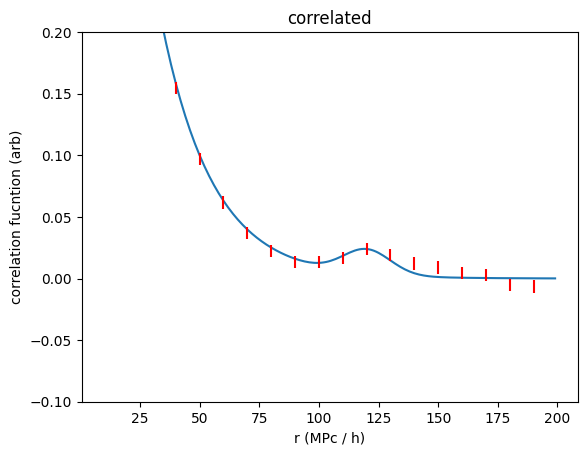

In [3]:
## make a toy modle for the galaxy-galaxy corerlation funciton

r = np.arange(190) + 10
gal_gal_cor_empricial_theory = 1*(1/10.)**(r/50.)+ 0.02*np.exp(-0.5*((r-120)/10.)**2)
plt.plot(r,gal_gal_cor_empricial_theory)
plt.xlabel("r (MPc / h)")
plt.ylabel("correlation fucntion (arb)")


## make simulated data with error bars, no correlation
bin_width = 10. # the sampling of the measurement
N_pts_in_bin  = 1000 # numper of samples used to compute the mean and rms in each bin
N_data_pts = int(190 / bin_width)  ## number of data points for the plot
sigma_corr = 0.005*np.sqrt(N_pts_in_bin)  ## uncertainty in the correlatoin fucntion
## new line
correlatipon_fator = 0.9  ###<<<<<<  nearest neighbor correlation factor <<<<<<<<<<<<<<<<<

## store all the data for future use
Raw_data = np.zeros([N_data_pts,N_pts_in_bin])
Binned_r = np.zeros(N_data_pts)
Binned_mean = np.zeros(N_data_pts)
Binned_error = np.zeros(N_data_pts)


## set up arrays so we can create nearesst neighbor correlation in the loop below
random_in_bin_last = np.random.randn(N_pts_in_bin)*sigma_corr + theory_mean
random_in_bin = np.random.randn(N_pts_in_bin)*sigma_corr + theory_mean
random_in_bin_next = np.random.randn(N_pts_in_bin)*sigma_corr + theory_mean


    
i = 0
while (i < N_data_pts):
    r_bin  = bin_width*(i+1)
    theory_mean = gal_gal_cor_empricial_theory[(np.where(r == r_bin))[0] ]
    ## inbclude correlations
    random_new = np.random.randn(N_pts_in_bin)
    
    ## update the random arrays
    random_in_bin_last = random_in_bin
    random_in_bin = random_in_bin_next
    random_in_bin_next = random_new
      
    ## compute the data point including correlation!!!!!!!! <<<<<<<<<<<<<<<<
    data_in_bin = + correlatipon_fator*random_in_bin_next + random_in_bin + correlatipon_fator*random_in_bin_last
    data_in_bin /= np.std(data_in_bin)  ## keep the standard devaition to be 1
    data_in_bin = data_in_bin*sigma_corr + theory_mean
        
    mean_pt = np.mean(data_in_bin)
    error_pt = np.std(data_in_bin) / np.sqrt(N_pts_in_bin - 1.) ## this is the error on the mean
    plt.errorbar(r_bin,mean_pt,error_pt,marker=',',mec='red',mfc='red',c="red")
  
    ## store the data for use below in a fit
    Raw_data[i,:] = data_in_bin
    Binned_r[i] = r_bin
    Binned_mean[i] = mean_pt
    Binned_error[i] = error_pt

    ## iterate
    i+=1

plt.title("correlated")
plt.ylim(-.1,.2)
plt.show()





### Excercise

Compare the correlated vs no-correlated cases.  How do they look different?   How can you visually assess if signfiicnat correlations are present in a measurment?  Look at the first detection of BAO-- do you think there were signifcant correlations in this measurment?

 your discusison goes in this cell

## Fitting and Paramter estimation

To fit we need a metrix of how well the data agree with the measurment.  Chi-squared provides just such a metric.   The definition of Chi-squared for uncorrelated data is $$ \chi ^2 = \Sigma_i \frac{(y_i - f(x_i))^2}{\sigma_i^2}.$$ Here $y_i$ are the data meaued as a function of some independant variable $x_i$ with variance $\sigma_i$.  We can also rewrite this using matrix and vector notation as $$ \chi ^2 = (\vec y - \vec f(x))^t N^{-2} ( \vec y - \vec f(x)).$$ In this equation $\vec y$ is a vector containing each of the data points sampled at $\vec x$, $\vec f(x)$ is a model for this data vector, and $N^{-2}$ (in the case of uncorrelated data) is a diagonal matrix with elements $ N^{-2}_{ii} = \frac 1 {\sigma_i^2}$.  When we include correlations we will swich $ N^{-2}_{ii} = \frac 1 {\sigma_i\sigma_j}$ to be the full covaraince matrix.

We will use $\chi^2$ in two ways.  First we can minimize it to find the bets fit.  In the examples below we will do a grid search-- there is an industry to minimization technques that are beyond the scope of this notebook.  Second, we can use $\chi^2$ to place error elipses on our fit.  If we want the $n$-$\sigma$ error eliplse, we just find where $\Delta \chi^2 = n^2$, where $\Delta \chi^2 = \chi^2 - min(\chi^2)$.  

One way to understand the use of $\Delta \chi^2$ in setting paramter errors,  is that if we had a single data point then  $\chi^2 = \frac {(y - m)^2} {\sigma^2}$.  In this case if the model $m$ is different from the data point $y$ by $n \sigma$ then $\chi^2$ would change by $n^2$ from its minima.   In the case of multiple data points this result can be generalized.  The can be easily checked by reruning a simulation of the measuremnt mutlipel times and looking at the variation in the simulated best fit parmaters.  These repeated simulations is the monty-carlo method.


### fitting funcitons and fit by eye

Here we define a fit funciton and attempt a fit by eye.


(-0.1, 0.2)

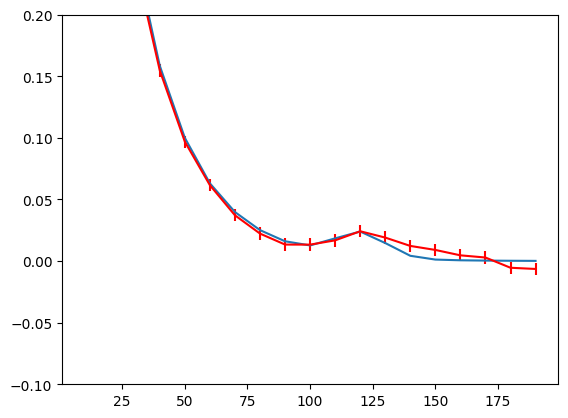

In [4]:
###### define a fitting function. 
#followiong the disccion above we generate a fitting funciton which takes three varibales: 
    ## A the amplitude of the power law
    ## B the ampltude of the gaussin feature represetning the BAO bump
    ## r the central values of r at which the data are sampled
def fit_funtion(A,B,r):
    return( A*(1/10.)**(r/50.)+ B*np.exp(-0.5*((r-120)/10.)**2))  ## the funciton we used to 


##### define a chi_sqared funmciton
## we will use the vector version and prepare for the case where correlations are present
def chi_squared(binned_r,binned_mean, invCov,A,B):
    model = fit_funtion(A,B,binned_r)
    data_minus_model = binned_mean - model
    chi_sq = np.dot( np.transpose(data_minus_model) , np.matmul(invCov, data_minus_model) )
    return(chi_sq)
    
    

plt.errorbar(Binned_r,Binned_mean,Binned_error,marker=',',mec='red',mfc='red',c="red")
plt.plot(Binned_r, fit_funtion(1,0.02,Binned_r))
#plt.plot(Binned_r, fit_funtion(0.8,-0.01,Binned_r))
#plt.plot(Binned_r, fit_funtion(1.3,0.04,Binned_r))
plt.ylim(-.1,.2)

### Excercise

adjust the paramters in the models aove to appriximate the 1 sigma errors for the model. Add a discsion to this cell.  These estimtes can be used for defining the search volume.

### carry out a fit ignoring correlations
Since we stored the "raw data" that go into the above plot, we can work from that for computing the mean and the covarinace matrix.

[0.986] [0.022] 11.433901004126508 19


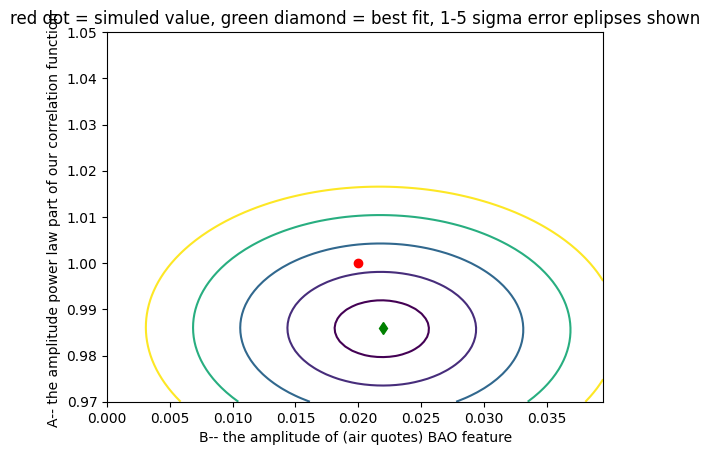

In [5]:
### fit ignoring correlations

### NOTE: the following quantities describing our simualted data were stored in the prvious cell:
    #Raw_data -- the data whcih go into each bin on the plot, these include correlations
    #Binned_r  -- the centra r of each bin
    #Binned_mean  -- the mean in each bin
    #Binned_error  -- the variance on the mean of each data point.

## define a grid in A and B and compute a grid search.

A_points = np.arange(0.97,1.05,.001)
B_points = np.arange(0.0,.04,.0005)
N_pts_A = np.size(A_points)
N_pts_B = np.size(B_points)
chi_sq_map = np.zeros([N_pts_A,N_pts_B])

## define a covariance mattix 
invCov_nocor = np.diag(Binned_error**(-2))


## compute chi_squared for each point
i = 0
while (i < N_pts_A):
    j = 0
    while (j < N_pts_B):
        chi_sq_map[i,j] = chi_squared(Binned_r,Binned_mean, invCov_nocor,A_points[i],B_points[j])
        j+=1
    i+=1


    
######
### make a plot of the 1,2,..5 sigma error contours on the fit, 
### show the "truth" from the simulations, and 
### show the best fit.

## make a plot of chi_sq
delta_chi_sq_map = chi_sq_map - np.min(chi_sq_map)
plt.contour(B_points,A_points,delta_chi_sq_map,levels=np.array([1,2**2,3**2,4**2,5**2]))


## plot the best fit
pos_min = np.where(chi_sq_map == np.min(chi_sq_map))
plt.plot(B_points[pos_min[1]],A_points[pos_min[0]],'gd')
print(A_points[pos_min[0]],B_points[pos_min[1]],np.min(chi_sq_map),np.size(Binned_r))


## plot the "true" parmaters (eg what we used in the simulation)
plt.plot(np.array(0.02),np.array(1),'ro')
plt.xlabel("B-- the amplitude of (air quotes) BAO feature")
plt.ylabel("A-- the amplitude power law part of our correlation function ")
plt.title("red dot = simuled value, green diamond = best fit, 1-5 sigma error eplipses shown")

plt.show()







### covarince matrices

In the above fit we used a diagnoal covarince matrix which ignores correlations.  Here we will visualize this covariance matrix before calculating the full covarince and repeating the fit using the full covariance.

C:\Users\Andrés Cook\AppData\Local\Temp\ipykernel_15740\4131733668.py:2: RuntimeWarning: divide by zero encountered in divide
  cov_matrix = 1./invCov_nocor


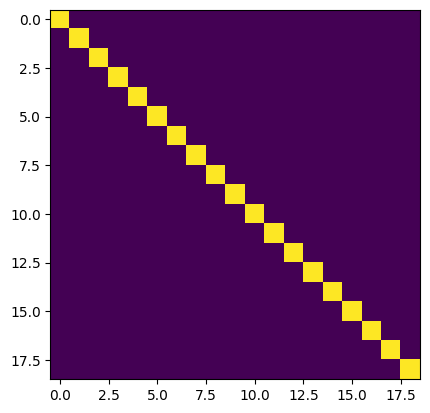

In [6]:
mask = np.where(invCov_nocor == 0)
cov_matrix = 1./invCov_nocor
cov_matrix[mask] = 0.

plt.imshow(cov_matrix,vmin = 0, vmax = np.max(cov_matrix))
plt.show()

Note how only the diagonal values are non-zero.


### covaraince matrix

We will now compute the covarince matrix accounting for correlations




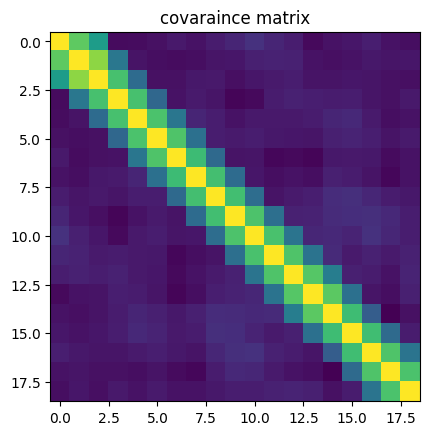

In [7]:
## compute the correlation matrix 

### NOTE: the following quantities describing our simualted data were stored in the prvious cell:
    #Raw_data -- the data whcih go into each bin on the plot, these include correlations
    #Binned_r  -- the centra r of each bin
    #Binned_mean  -- the mean in each bin
    #Binned_error  -- the variance on the mean of each data point.
    
    
cov = np.zeros([np.size(Binned_r),np.size(Binned_r)])  ## make a matrix to hold the covariance


## compute the covarinace from the Raw data in each bin
i = 0
while (i < np.size(Binned_r)):
    j = 0
    while (j < np.size(Binned_r)):
        di = Raw_data[i,:]-np.mean(Raw_data[i,:])
        dj = Raw_data[j,:]-np.mean(Raw_data[j,:])
        cov[i,j] = ( np.sum(di*dj) / (N_pts_in_bin**2))   ## note how easy this is.  The N_pts_in_bin^2 factor is so we get the covariance on the mean
        j+=1
    i+=1


## plot the covaraince matrix.
plt.imshow(cov)
plt.title("covaraince matrix")
plt.show()

### Excercise:
Compute the correlation matrix for these data

In [8]:
## your code goes here

Computing  $\chi^2$ requires the inverse of the covaraince matrix.  Given thave covariance matrices often have singular (zero) eigenvalues we will use the singular value decompositin to carry out the inversion.  If any of the eigenvalues are found to be zero these could be regulerized.  

det(cov) 3.371266028165899e-97
the small value looks scarry-- lets see if this is dominated by one eigenvalue by printing these out
[7.58062849e-05 7.11356322e-05 6.56304903e-05 5.97955670e-05
 5.39693767e-05 4.15456077e-05 3.12653127e-05 2.55218736e-05
 1.57014974e-05 9.19427485e-06 6.32140216e-06 5.65475880e-06
 4.75500199e-06 3.39139271e-06 2.68318568e-06 1.15810370e-06
 1.11629521e-06 1.98736687e-07 1.55205821e-07]
since all eigenvalues are approximatly the same size we can safely invert this matrix


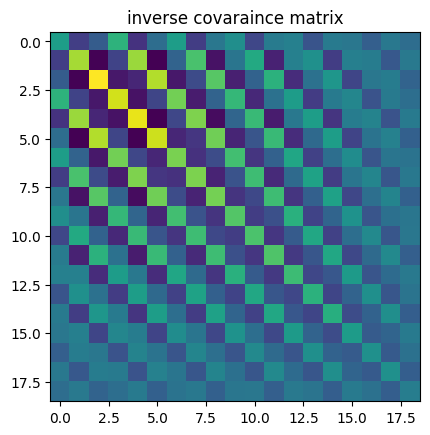

In [9]:
## check the determinant of the covariance matrix-- if this is small it may be a sign of a signular eigenvalue
print("det(cov)",np.linalg.det(cov))

print("the small value looks scarry-- lets see if this is dominated by one eigenvalue by printing these out")
u,s,v=np.linalg.svd(cov)
print(s)
print("since all eigenvalues are approximatly the same size we can safely invert this matrix")
inv_cov=np.dot(v.transpose(),np.dot(np.diag(s**-1),u.transpose()))

## plot the inverse covaraince matrix
inv_cov = np.linalg.inv(cov)
plt.imshow(inv_cov)
plt.title("inverse covaraince matrix")
plt.show()

## optional check to verify the inversion worked
#test = np.matmul(inv_cov,cov)
#plt.imshow(test)
#plt.show()

## now repeat the fit using this full inverse covaraince to compute Chi-squared

[1.004] [0.014] 17.85882809681128 19


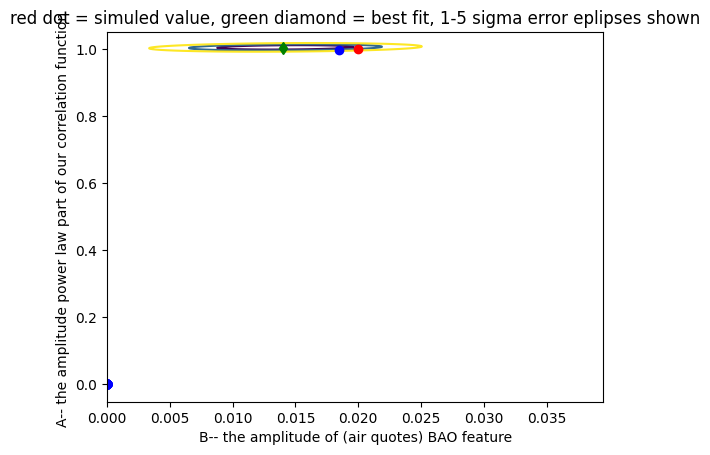

In [22]:

## compute chi_squared for each point
i = 0
while (i < N_pts_A):
    j = 0
    while (j < N_pts_B):
        chi_sq_map[i,j] = chi_squared(Binned_r,Binned_mean, inv_cov,A_points[i],B_points[j])
        j+=1
    i+=1

    
delta_chi_sq_map = chi_sq_map - np.min(chi_sq_map)

   
######
### make a plot of the 1,2,..5 sigma error contours on the fit, 
### show the "truth" from the simulations, and 
### show the best fit.

## make a plot of chi_sq
delta_chi_sq_map = chi_sq_map - np.min(chi_sq_map)
plt.contour(B_points,A_points,delta_chi_sq_map,levels=np.array([2.3,4.61,9.21]))


## plot the best fit
pos_min = np.where(chi_sq_map == np.min(chi_sq_map))
plt.plot(B_points[pos_min[1]],A_points[pos_min[0]],'gd')
print(A_points[pos_min[0]],B_points[pos_min[1]],np.min(chi_sq_map),np.size(Binned_r))


## plot the "true" parmaters (eg what we used in the simulation)
plt.plot(np.array(0.02),np.array(1),'ro')
plt.xlabel("B-- the amplitude of (air quotes) BAO feature")
plt.ylabel("A-- the amplitude power law part of our correlation function ")
plt.title("red dot = simuled value, green diamond = best fit, 1-5 sigma error eplipses shown")

#Now we generate 100 more simulations...
N_sims = 100
A_min = np.zeros((N_sims,1))
B_min = np.zeros((N_sims,1))
chisq_min = np.zeros((N_sims,1))
for j in range(1,N_sims):
    ## make simulated data with error bars, no correlation
    bin_width = 10. # the sampling of the measurement
    N_pts_in_bin  = 1000 # numper of samples used to compute the mean and rms in each bin
    N_data_pts = int(190 / bin_width)  ## number of data points for the plot
    sigma_corr = 0.005*np.sqrt(N_pts_in_bin)  ## uncertainty in the correlatoin fucntion
    ## new line
    correlatipon_fator = 0.9  ###<<<<<<  nearest neighbor correlation factor <<<<<<<<<<<<<<<<<

    ## store all the data for future use
    Raw_data = np.zeros([N_data_pts,N_pts_in_bin])
    Binned_r = np.zeros(N_data_pts)
    Binned_mean = np.zeros(N_data_pts)
    Binned_error = np.zeros(N_data_pts)


    ## set up arrays so we can create nearesst neighbor correlation in the loop below
    random_in_bin_last = np.random.randn(N_pts_in_bin)*sigma_corr + theory_mean
    random_in_bin = np.random.randn(N_pts_in_bin)*sigma_corr + theory_mean
    random_in_bin_next = np.random.randn(N_pts_in_bin)*sigma_corr + theory_mean


        
    i = 0
    while (i < N_data_pts):
        r_bin  = bin_width*(i+1)
        theory_mean = gal_gal_cor_empricial_theory[(np.where(r == r_bin))[0] ]
        ## inbclude correlations
        random_new = np.random.randn(N_pts_in_bin)
        
        ## update the random arrays
        random_in_bin_last = random_in_bin
        random_in_bin = random_in_bin_next
        random_in_bin_next = random_new
        
        ## compute the data point including correlation!!!!!!!! <<<<<<<<<<<<<<<<
        data_in_bin = + correlatipon_fator*random_in_bin_next + random_in_bin + correlatipon_fator*random_in_bin_last
        data_in_bin /= np.std(data_in_bin)  ## keep the standard devaition to be 1
        data_in_bin = data_in_bin*sigma_corr + theory_mean
            
        mean_pt = np.mean(data_in_bin)
        error_pt = np.std(data_in_bin) / np.sqrt(N_pts_in_bin - 1.) ## this is the error on the mean
    
        ## store the data for use below in a fit
        Raw_data[i,:] = data_in_bin
        Binned_r[i] = r_bin
        Binned_mean[i] = mean_pt
        Binned_error[i] = error_pt

        ## iterate
        i+=1

    ## compute the covarinace from the Raw data in each bin
    i = 0
    while (i < np.size(Binned_r)):
        j = 0
        while (j < np.size(Binned_r)):
            di = Raw_data[i,:]-np.mean(Raw_data[i,:])
            dj = Raw_data[j,:]-np.mean(Raw_data[j,:])
            cov[i,j] = ( np.sum(di*dj) / (N_pts_in_bin**2))   ## note how easy this is.  The N_pts_in_bin^2 factor is so we get the covariance on the mean
            j+=1
        i+=1
    cov = np.zeros([np.size(Binned_r),np.size(Binned_r)])  ## make a matrix to hold the covariance
    inv_cov=np.dot(v.transpose(),np.dot(np.diag(s**-1),u.transpose()))
    
    ## compute chi_squared for each point
    chi_sq_map = np.zeros([N_pts_A,N_pts_B])
    ii = 0
    while (ii < N_pts_A):
        jj = 0
        while (jj < N_pts_B):
            chi_sq_map[ii,jj] = chi_squared(Binned_r,Binned_mean, inv_cov,A_points[ii],B_points[jj])
            jj+=1
        ii+=1
    ind_min = np.where(chi_sq_map == np.min(chi_sq_map))
    A_min[i] = A_points[ind_min[0]]
    B_min[i] = B_points[ind_min[1]]
    chisq_min[i] = chi_sq_map[ind_min]
plt.plot(B_min,A_min,'bo')

## Notes: 

1. Including the correlations through the covariance changed the bet fit and the erorr bars.  Ignoring correlations in fitting data can lead to incorrect results.

1. The significnace of the detector of the "B" paramter (e.g., the "BAO" bump amplitude) changed when correlations were includede--  in the case stored in this notebook the detetion signficance decreased to below 4 sigma compared to > 5 when corelations were ignored.   Correlations are critical for drawing conclusions from data.

1. The error elipises computing with correlations have a tilt indicating that the errors on the $A$ and $B$ paramters are correlated.

1. You can rerun this notebook multiple times to see how different random variations in the measuremnt with the same statistical weight can cahnge the results.  Note that one realization my be 5 sigma, but others could be higher or lower.   This variation in the detection signficance is one of the reasons 5 sigma is addopted as a critical threshold for claiming a detection.

1. The method we used here is direct and theirfore straightforward to understand.  A huge body of methods exist to speed up fits and estimate of errors on fit paramters.  These include monty-carlo methods, Fisher information mateix (second derivitve of Chi-sq), and others.  This notebook shold give you a framework for thinking about what is going on in these methods. 

1. many other types of noise correaltions exist.  Below we will play with a different example as an excercise.

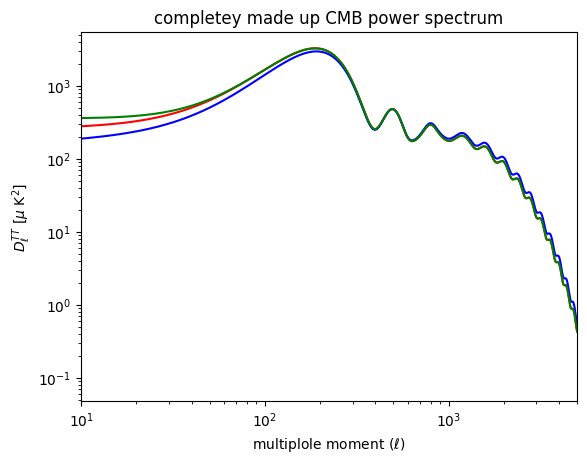

In [11]:
ell = np.arange(6000)

def toy_CMB_TT(ell,ns,r):
    Dl_toy= 20 + 5* np.cos(2*np.pi / 400*ell)/2.
    Dl_toy*= ell*(ell+1)  /10000.
    Dl_toy+= 10000* np.exp(-.5*((ell+300)/100)**2 )
    Dl_toy+= 5000* np.exp(-.5*((ell-200)/75)**2 )
    Dl_toy+= 1000* np.exp(-.5*((ell-500)/50)**2 )
    Dl_toy+= 400* np.exp(-.5*((ell-800)/50)**2 )
    Dl_toy*= (1/10)**((ell)/1000)
    Dl_toy*= (ell / 500.)**(-(ns-1.))
    Dl_toy+= 10000* np.exp(-.5*((ell+300)/100)**2 )*r
    return(Dl_toy)


plt.loglog(ell,toy_CMB_TT(ell,1,0),"r")
plt.loglog(ell,toy_CMB_TT(ell,0.9,0),"b")
plt.loglog(ell,toy_CMB_TT(ell,1,1),"g")
plt.title("completey made up CMB power spectrum")
plt.xlabel("multiplole moment $(\ell)$")
plt.ylabel("$D_\ell^{TT}$ [$\mu$ K$^2$]")
plt.xlim(10,5000)
plt.show()


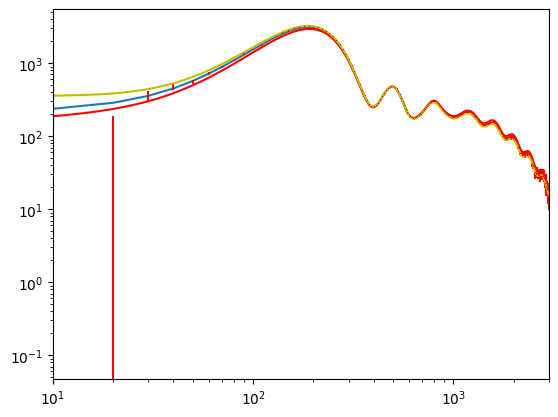

In [12]:
## make fake data

ell_measure = np.arange(10,3000,10)
DL_sim = toy_CMB_TT(ell_measure,0.96,0)
N_bins = np.size(ell_measure)
N_pts_in_bin = 1000
## arrays to store the results for future use
Raw_data = np.zeros([N_bins,N_pts_in_bin])
Binned_mean = np.zeros(N_bins)
Binned_error = np.zeros(N_bins)

plt.loglog(ell_measure,DL_sim)


## make a model of the beam calibraiton error-- this will lead to the correlated error
beam_sigma = 2./60. *np.pi/180. /np.sqrt(8*np.log(2))
beam= np.exp(-ell_measure * (ell_measure+1)*beam_sigma**2)
beam_corr= np.exp(-ell_measure * (ell_measure+1)*(beam_sigma*0.99)**2)
  #plt.plot(ell_measure,beam-beam_corr)
beam_error = (beam-beam_corr)

## make an evelovpe of the error vs ell from sample variance of the sky
N_SV = 1. / (ell_measure*(ell_measure+1)) * DL_sim*100
## make an evelovpe of the error vs ell from sample variance of the sky
N_beam = 1. / beam

#error uncorrelated envelope
Noise_uncorrelated = N_SV + N_beam

noise_amplitude = 50.


beam_random = np.random.randn(N_pts_in_bin)

i = 0
while (i < N_bins):
    data_in_bin = np.random.randn(N_pts_in_bin) * Noise_uncorrelated[i]* noise_amplitude
    data_in_bin += beam_random * beam_error[i]*DL_sim[i]*100
    data_in_bin += DL_sim[i]
    
        
    mean_pt = np.mean(data_in_bin)
    error_pt = np.std(data_in_bin) / np.sqrt(N_pts_in_bin - 1.) ## this is the error on the mean
    plt.errorbar(ell_measure[i],mean_pt,error_pt,marker=',',mec='red',mfc='red',c="red")
  
    ## store the data for use below in a fit
    Raw_data[i,:] = data_in_bin
    Binned_mean[i] = mean_pt
    Binned_error[i] = error_pt
    ## note ell_measure is also needed
    i+=1
    
    
plt.loglog(ell,toy_CMB_TT(ell,0.9,0),"r")
plt.loglog(ell,toy_CMB_TT(ell,1,1),"y")
plt.xlim(10,3000)
plt.show()

## Excercise 

Use the tecniques above to fit ns and r from thsi toy model of the temperture spectrum toy model presented here.  

NOTE: to do thsi correctly you could generate a complete noise model, use CAMB to generate the theory (rahter than our toy model), and then sample the paratmer space using a montycarlo method.  This toy model illustrates different types of correlations from what was presented earlier, and give you a chance to practice the technqiues of this notebook.